# Image Recognition - Logistic Regression
---

In this two-part project, we first explore image recognition using Logistic Regression. The subsequent segment contrasts this with Torchvision, offering a comparative insight into both methodologies.

---

![title](header_image.jpg)

Data source for this project - https://www.cs.toronto.edu/~kriz/cifar.html

*Recommended to download the file and save in the same directory of the jupyter notebook*

---

## Packages and Instalations

In [1]:
# Imports
from platform import python_version
import time
import math
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# python and package version
# install watermark package if do not have -> !pip install -q -U watermark

%reload_ext watermark
print('Python:', python_version())
%watermark --iversions

Python: 3.9.13
numpy     : 1.21.5
matplotlib: 3.5.2



---

## Class for Load, Process and Handle image data

In [3]:
class DataLoader:
    """
    A class to handle and process image data from the CIFAR-10 dataset.
    """
    
    def __init__(self, base_path="cifar-10-batches-py/"):
        """
        Initialize DataLoader with the base directory of the CIFAR-10 data.
        """
        self.base_path = base_path
        
    def load_data(self, filename):
        """
        Load and preprocess the CIFAR-10 image data.
        """
        
        # Construct the full path of the file
        filename = self.base_path + filename
        
        # Load the data from the file
        with open(filename, mode='rb') as file:
            data = pickle.load(file, encoding='bytes')
        
        # Extract raw images and labels
        raw_images = data[b'data']
        y = np.array(data[b'labels'])
        
        # Normalize the raw image data
        raw_float = np.array(raw_images, dtype=float) / 255.0
        
        # Reshape and transpose the image data for visualization
        images = raw_float.reshape([-1, 3, 32, 32]).transpose([0, 2, 3, 1])
        
        # Flatten the image data for ML algorithms
        X = images.reshape((images.shape[0], 3*32*32))
        
        return X, y

    def format_data(self, X, Y, v0, v1):
        """
        Filter and format data based on specific class labels.
        """
        
        # Calculate the maximum of the two labels
        lg = max(v0, v1)
        
        # Identify data points with labels v0 or v1
        indices = [i for i in range(len(Y)) if Y[i] == v0 or Y[i] == v1]
        
        # Filter and adjust the data accordingly
        X = np.squeeze(np.take(X, indices, axis=0))
        Y = np.squeeze(np.floor(np.divide(np.take(Y, indices, axis=0), lg)))
        
        return X, Y

    def prepare_data(self, batch_number, start_val, end_val):
        """
        Load and format a specific batch of CIFAR-10 data.
        """
        
        # Load the data using the specified batch number
        x_train, y_train = self.load_data(f"data_batch_{batch_number}")
        
        # Format the data based on the specified range
        x_train, y_train = self.format_data(x_train, y_train, start_val, end_val)
        
        return x_train, y_train
    
    
    def load_new_images(self, filename):
        """
        Load images without processing.
        """
        # Construct the full path of the file
        filename = self.base_path + filename
        
        # Load the data from the file
        with open(filename, mode='rb') as file:
            data = pickle.load(file, encoding='bytes')
        
        # Extract raw images
        raw_images = data[b'data']
        
        # Normalize the raw image data
        raw_float = np.array(raw_images, dtype=float) / 255.0
        
        # Reshape and transpose the image data for visualization
        images = raw_float.reshape([-1, 3, 32, 32]).transpose([0, 2, 3, 1])
        
        # Extract labels
        labels = np.array(data[b'labels'])
        
        return images, labels


---

## Logistic Regression from Scratch

Creating a Logistic Regression model from scratch (no framework used)

In [4]:
class LogisticRegressionModel:
    """
    A class for the Logistic Regression model.
    """
    
    def __init__(self):
        self.beta = None
        self.likelihood_history = []
        self.iteration_history = []

    def fit(self, X, Y, epsilon, learning_rate, start, end, beta=0, max_iter=2000):
        """
        Train the Logistic Regression model using Gradient Descent.
        """
        
        # Slice the data based on provided indices
        X = X[start:end]
        Y = Y[start:end]
                
        # Determine the number of dimensions in the feature data
        dimensions = X.shape[1]
        
        # Initialize containers for likelihood values and iterations
        likelihood0 = []
        delta = 0
        itr = 0
        itrs = []
        
        # Initialize weights (beta) if not provided
        if beta == 0:
            beta = np.array([random.random() * 0 for _ in range(dimensions)])
        
        # Gradient Descent for optimization
        while True:
            # Gradient Descent - Calculate the gradient of the log likelihood w.r.t. weights 
            grad = LogisticRegressionModel._calculate_gradient(beta, X, Y)
            
            # Update the weights
            beta = beta + (learning_rate * grad)
            
            # Calculate the log likelihood with the updated weights ("model error")
            log = LogisticRegressionModel._log_likelihood(beta, X, Y)
            likelihood0.append(log)
            itr += 1
            itrs.append(itr)
            
            # Check convergence criteria
            delta = np.linalg.norm(grad)
            if delta < epsilon or itr > max_iter:
                break
        
        # Update instance attributes
        self.beta = beta
        self.likelihood_history = likelihood0
        self.iteration_history = itrs
        
        return beta, likelihood0, itrs
        
    @staticmethod
    def _log_likelihood(beta, X, Y):
        """
        Compute the log likelihood (loss function) for the given data and weights.
        """
        
        # Compute the dot product of feature data and weights
        t = np.dot(X, beta.T)
        
        # Adjust the labels
        w = np.subtract(Y, 1)
        
        # Compute likelihood using weights
        w = np.dot(w, t)
        
        # Apply the logistic function
        m = np.power(math.e, -t)
        m = np.add(1, m)
        
        # Calculate the log likelihood
        z = np.log(m)
        z = np.sum(z)
        
        return w - z

    @staticmethod
    def _calculate_gradient(beta, X, Y):
        """
        Calculate the gradient of the log likelihood w.r.t. the weights.
        """
        
        # Subtract the bias term
        z = np.subtract(Y, 1)
        
        # Compute the dot product of feature data and weights
        w = np.power(math.e, np.dot(-X, beta.T))
        
        # Compute the predicted probabilities
        p = np.divide(w, np.add(1, w))
        
        # Calculate the gradient (delta)
        q = z + p
        delta = np.dot(q, X)
        
        return delta

    
    def predict(self, X, Y):
        """
        Predict class labels using the Logistic Regression model.
        """
        
        # Compute the dot product of feature data and weights
        z = np.dot(X, self.beta)
        
        # Logistic Regression function
        # Calculate the predicted probabilities using the logistic regression function 
        predY = (1/(1+np.exp(-z)))
        
        # Round the probabilities to get class labels
        predY = np.around(predY)
        
        # Identify correct and incorrect predictions
        correct = [[], []]
        incorrect = [[], []]
        for i in range(len(X)):
            if predY[i] == Y[i]:
                correct[int(Y[i])].append(i)
            else:
                incorrect[int(Y[i])].append(i)
        return correct, incorrect
    
    
    @staticmethod
    def evaluate(correct, incorrect, total):
        """
        Evaluate the model's performance based on correct and incorrect predictions.
        
        Args:
        - correct: Indices of correct predictions.
        - incorrect: Indices of incorrect predictions.
        - total: Total number of predictions.
        
        Outputs:
        - Prints the model's accuracy.
        """
        
        # Count the number of correct predictions for each class
        correct_count = len(correct[0]) + len(correct[1])
        
        # Calculate the accuracy
        accuracy = (correct_count / total) * 100
        print(f"Model Accuracy: {accuracy:.2f}%")


---

## Image Handler and train data
Using DataLoader class


In [5]:
# Data Loading and Formatting
handler = DataLoader()
start_val = 0
end_val = 3
train_batch = 1
x_train, y_train = handler.prepare_data(train_batch, start_val, end_val)

---

## Hyperparameters
Hyperparameters to be used on LogisticRegressionModel class

In [6]:
# Hyperparameters
epsilon = 0.02  # Stopping criterion
learning_rate = 0.000005  # Controls the speed of training
start = 0  # Starting point of the data for training
end = len(x_train)  # Ending point of the data for training
max_iterations = 1000  # Maximum number of iterations

---

## Instantiating and Training Logistic Regression Model

In [7]:
%%time
# Model Training
regressor = LogisticRegressionModel()
beta, likelihood0, itrs = regressor.fit(X=x_train,
                                        Y=y_train,
                                        epsilon=epsilon,
                                        learning_rate=learning_rate,
                                        start=start,
                                        end=end,
                                        max_iter=max_iterations)


Wall time: 18.8 s


---

## Log Likelihood over Iterations - plot


#### Relevance of the Log Likelihood vs. Iterations plot for the Model Analysis:

##### Convergence Check:
One of the main uses of this plot is to check for the convergence of the gradient descent algorithm. If the log likelihood stabilizes (flattens out) and doesn't change much with more iterations, it's an indication that the algorithm has converged, and further iterations might not significantly improve the model fit.

##### Learning Rate Diagnosis:
If the log likelihood oscillates or diverges (i.e., goes to negative infinity), it could indicate issues like a learning rate that's too high. In contrast, if the convergence is very slow, it might mean the learning rate is too low.

##### Overfitting/Underfitting Diagnosis:
If the log likelihood on a validation set starts decreasing while it continues to increase on the training set, it could be an indication of overfitting.

In essence, this plot provides valuable feedback on the training process, model fit, and potential issues with the gradient descent parameters.

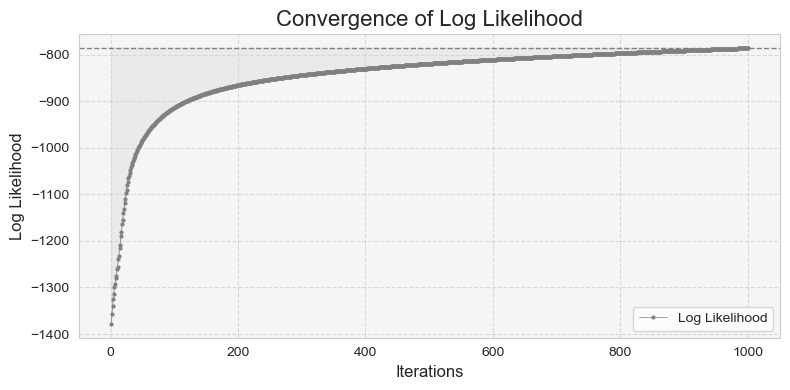

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a custom style using Seaborn
sns.set_style("whitegrid")

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the data with adjusted line thickness and marker size
ax.plot(itrs, likelihood0, marker='o', markersize=2, linestyle='-', linewidth=0.5, color='gray', label='Log Likelihood')

# Add title and labels
ax.set_title("Convergence of Log Likelihood", fontsize=16)
ax.set_xlabel("Iterations", fontsize=12)
ax.set_ylabel("Log Likelihood", fontsize=12)

# Add grid and legend
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

# Highlight the region of convergence
ax.axhline(y=max(likelihood0), color='gray', linestyle='--', linewidth=1)
ax.fill_between(itrs, likelihood0, max(likelihood0), color='lightgray', alpha=0.3)

# Add a subtle background color
ax.set_facecolor('#f5f5f5')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

---

## Prediction, Test and Accuracy
Using the trained model and test data from the **test_batch**

In [9]:
# Load and format the test data
x_test_raw, y_test_raw = handler.load_data("test_batch")
x_test, y_test = handler.format_data(x_test_raw, y_test_raw, start_val, end_val)

# Predict using the trained model
correct, incorrect = regressor.predict(x_test, y_test)

# Evaluate the performance of the model
regressor.evaluate(correct, incorrect, len(y_test))

Model Accuracy: 81.65%


---

## Displaying Images

* Classified **Correctly**

In [10]:
# Loading new images
images, labels = handler.load_new_images("test_batch")

# Filter for specific labels
bloco_start = 0
bloco_end = 3
selected_images = [img for i, img in enumerate(images) if bloco_start <= labels[i] <= bloco_end]

Displaying some images classified correctly: 


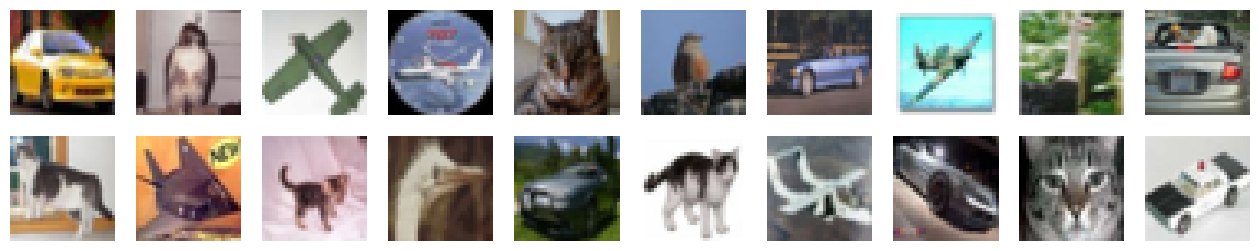

In [11]:
print("Displaying some images classified correctly: ")

fig, axes1 = plt.subplots(2, 10, figsize=(16, 3))
for j in range(2):
    for k in range(10):
        i = random.choice(correct[j])
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(selected_images[i])
        
plt.show()

* Classified **Incorrectly**

Displaying some images classified incorrectly: 


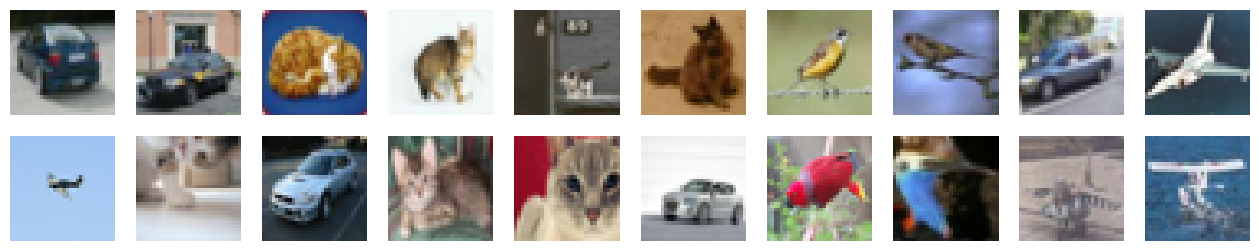

In [12]:
print("Displaying some images classified incorrectly: ")

fig, axes1 = plt.subplots(2, 10, figsize=(16, 3))
for j in range(2):
    for k in range(10):
        i = random.choice(incorrect[j])
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(selected_images[i])

plt.show()

---

## Additioonal Content
### Math Theory
Relevant mathematical theory applied to create the Logistic Regression model

* **Log Likelihood**

---

The function `_func_log_likelihood` computes the log likelihood for a logistic regression model. Below the break down the relationship between the given code and the mathematical formulation of the log likelihood for logistic regression.

The log likelihood for logistic regression is given by:

$$
L(\beta) = \sum_{i=1}^{n} [y_i \beta^T x_i - \log(1 + e^{\beta^T x_i})]
$$

Where:
- $n$ is the number of samples.
- $y_i$ is the actual label of the $i^{th}$ sample.
- $\beta$ is the vector of coefficients.
- $x_i$ is the feature vector of the $i^{th}$ sample.


Formula break down:

1. $y_i \beta^T x_i$: 
    - This term represents the weighted sum of features for sample $i$, scaled by the corresponding label $y_i$. If $y_i$ is 1, this term becomes $ \beta^T x_i$. If $y_i$ is 0, this term becomes 0 (because $y_i$ would be 0).

2. $\log(1 + e^{\beta^T x_i})$: 
    - This term represents the logarithm of the sum of 1 and the exponential of the weighted sum of features. It's the logarithm of the denominator of the sigmoid function.

Mapping the steps in the code to these terms:

1. $ t = X \times \beta^T $: 
    - This computes the linear combination of features and weights, which represents $ \beta^T x_i $ in the formula.

2. $ w = Y - 1 $: 
    - Here, `Y` is a binary label (either 0 or 1). Subtracting 1, this operation adjusts the actual labels. It will result in -1 for actual labels 0 and 0 for actual labels 1.

3. $ w = w \times t $:
    - This computes $y_i \beta^T x_i$ for $y_i = 1$ and $-\beta^T x_i$ for $y_i = 0$. This accounts for the first term in the summation of the log likelihood formula.

4. $ m = \frac{1}{1 + e^{-t}} $:
    - This computes the sigmoid function. Note that the denominator here is $1 + e^{-t}$. Taking the natural logarithm of this denominator gives the second term in the summation of the log likelihood formula.

5. $ z = \sum_{i} \log(m_i) $:
    - This computes the sum of the logarithm of the predicted probabilities.

Finally, the function returns $ w - z $. This corresponds to summing up $y_i \beta^T x_i - \log(1 + e^{\beta^T x_i})$ for all samples $i$, which is our log likelihood formula.

The rearrangement in the code is for computational efficiency and clarity. The essence remains faithful to the mathematical formulation of the log likelihood in logistic regression.


* **Gradient Descent**
---

The function `_gradient_calc` computes the gradient of the log likelihood with respect to the weights (coefficients) for the logistic regression model. The gradient indicates the direction and magnitude of change required in the weights to improve the model fit. Let's first understand the general mathematical formulation of the gradient for logistic regression.

The gradient of the log likelihood for logistic regression is given by:

$$
\nabla L(\beta) = \sum_{i=1}^{n} (y_i - p_i) x_i
$$

Breaking down the formula:

1. $y_i$: 
    - This term represents the actual label of the $i^{th}$ sample. It's either 0 or 1 in binary classification.
    
2. $p_i$: 
    - Represents the predicted probability of the $i^{th}$ sample being in the positive class (label 1). It's computed using the sigmoid function as $p_i = \frac{1}{1 + e^{-\beta^T x_i}}$.

3. $y_i - p_i$: 
    - This is the residual for the $i^{th}$ sample, capturing the difference between the observed outcome and the predicted probability.

4. $(y_i - p_i) x_i$: 
    - This is the residual weighted by the feature values for the $i^{th}$ sample. It gives the direction and magnitude of change required for each feature's weight.

Mapping the steps in the code to these terms:

1. $ z = Y - 1 $: 
    - This step adjusts the actual labels. It transforms a label of 0 to -1 and keeps a label of 1 unchanged. This transformation simplifies the computation of the residuals.

2. $ w = e^{-X \times \beta^T} $: 
    - This computes the exponential term of the denominator of the sigmoid function.

3. $ p = \frac{w}{1 + w} $: 
    - This computes the predicted probabilities using the sigmoid function.

4. $ q = z + p $: 
    - Combines the adjusted labels and the predicted probabilities, resulting in the residuals $y_i - p_i$.

5. $ \delta = q \times X $: 
    - Computes the gradient by weighting the residuals with the feature values.

In essence, the function calculates the direction and magnitude of change required in the weights to maximize the log likelihood. The gradient descent algorithm then uses this gradient to adjust the weights in the direction that maximizes the log likelihood, improving the fit of the logistic regression model.



Certainly! Here's a summarized version in a Jupyter markdown format:

---

### Logistic Regression Function

**Logistic Regression** is a statistical method tailored for binary classification problems. It predicts the probability of an instance belonging to a default class, which can be converted into a binary outcome via a threshold (e.g., if \( p > 0.5 \), predict class 1, else predict class 0).

The main function used in Logistic Regression is the **Sigmoid Function**:

$$
\sigma(z) = \frac{1}{{1 + e^{-z}}}
$$

Where:
- $ \sigma(z) $ is the output between 0 and 1.
- $ e $ is the base of natural logarithms.
- $ z $ is a linear combination of inputs and weights.

The sigmoid function maps any input into a value between 0 and 1, making it useful for a probability representation. The goal of logistic regression is to best estimate the probability of the default class.

---

**Sigmoid function (for ilustration only):**

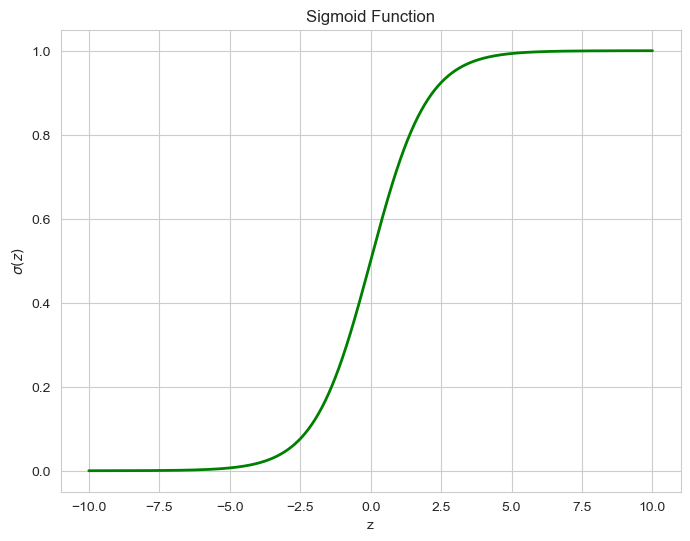

In [13]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Generate values
z = np.linspace(-10, 10, 1000)
y = sigmoid(z)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(z, y, 'g-', linewidth=2)
plt.title("Sigmoid Function")
plt.xlabel("z")
plt.ylabel("$\sigma(z)$")
plt.grid(True)
plt.show()